# Análise dos acidentes de trânsito na Nigéria entre 2020 e 2024
Utilizando PySpark

### Importanto e configurando o ambiente para uso da biblioteca PySpark

In [86]:
# Importando as bibliotecas que usaremos para ter a localização do pyspark
import findspark
import os

# Configura o caminho do Spark
os.environ["SPARK_HOME"] = '/Users/marcusferreira/Documents/Vscode/PySpark/spark-3.4.0-bin-hadoop3'

# Inicializa o findspark, para ele localizar onde está armazenado
findspark.init()

# Biblioteca do Spark para utilização de DataFrame e linguagem SQL
from pyspark.sql import SparkSession

# Importando as funções SQL do PySpark para utilizarmos ao longo do código
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import IntegerType

# Importando bibliotecas auxiliares
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Inicializa uma SparkSession com um nome de aplicação descritivo
spark = SparkSession.builder \
    .appName("AnaliseAcidentesTransito") \
    .master('local[*]') \
    .getOrCreate()

# Obtém o SparkContext a partir da SparkSession
sc = spark.sparkContext

### Obtendo o arquivo e fazendo algumas análises iniciais

In [87]:
# Obtendo o arquivo CSV e criando um DataFrame a partir dele
path = '/Users/marcusferreira/Documents/Vscode/Traffic_crashes/NigerianTrafficCrashes.csv'
df = spark.read.option('delimiter', ',').option("header", True).csv(path)

# Visualizando o DataFrame
df.show()

# Verificação dos tipos de campos
df.printSchema()

# Verificando os casos nulos
null_counts = df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in df.columns])
null_counts.show()

+-------+-----------+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+
|Quarter|      State|Total_Crashes|Num_Injured|Num_Killed|Total_Vehicles_Involved|SPV|DAD|PWR|FTQ|Other_Factors|
+-------+-----------+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+
|Q4 2020|       Abia|           30|        146|        31|                     37| 19|  0|  0|  0|           18|
|Q4 2020|    Adamawa|           77|        234|        36|                     94| 57|  0|  0|  0|           37|
|Q4 2020|  Akwa Ibom|           22|         28|         7|                     24| 15|  0|  0|  1|            8|
|Q4 2020|    Anambra|           72|        152|        20|                     83| 43|  1|  0|  0|           39|
|Q4 2020|     Bauchi|          154|        685|        90|                    140| 74|  0|  0|  0|           66|
|Q4 2020|    Bayelsa|            1|          3|         0|                      1|  1|  0|  0|  

### Aplicando tratamento de dados

In [88]:
# Alterando os tipos das colunas para o formato correto
df = df.withColumn('Total_Crashes', df['Total_Crashes'].cast(IntegerType()))
df = df.withColumn('Num_Injured', df['Num_Injured'].cast(IntegerType()))
df = df.withColumn('Num_Killed', df['Num_Killed'].cast(IntegerType()))
df = df.withColumn('Total_Vehicles_Involved', df['Total_Vehicles_Involved'].cast(IntegerType()))
df = df.withColumn('SPV', df['SPV'].cast(IntegerType()))
df = df.withColumn('DAD', df['DAD'].cast(IntegerType()))
df = df.withColumn('PWR', df['PWR'].cast(IntegerType()))
df = df.withColumn('FTQ', df['FTQ'].cast(IntegerType()))
df = df.withColumn('Other_Factors', df['Other_Factors'].cast(IntegerType()))
df.printSchema()
df.show(10)

root
 |-- Quarter: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Total_Crashes: integer (nullable = true)
 |-- Num_Injured: integer (nullable = true)
 |-- Num_Killed: integer (nullable = true)
 |-- Total_Vehicles_Involved: integer (nullable = true)
 |-- SPV: integer (nullable = true)
 |-- DAD: integer (nullable = true)
 |-- PWR: integer (nullable = true)
 |-- FTQ: integer (nullable = true)
 |-- Other_Factors: integer (nullable = true)

+-------+-----------+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+
|Quarter|      State|Total_Crashes|Num_Injured|Num_Killed|Total_Vehicles_Involved|SPV|DAD|PWR|FTQ|Other_Factors|
+-------+-----------+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+
|Q4 2020|       Abia|           30|        146|        31|                     37| 19|  0|  0|  0|           18|
|Q4 2020|    Adamawa|           77|        234|        36|                     94| 57| 

### Análise Exploratória
Verificando em cada quarter qual foi o total de crashes, além disso, comparar se os quartes finais tem mais acidentes do que os primeiros, dado a pandemia do COVID-19

In [89]:
# Criando uma coluna de indíce para cada Quarter
df = df.withColumn('Index_Quarter', when(df['Quarter'] == "Q4 2020", 1)
    .when(df['Quarter'] == "Q1 2021", 2)
    .when(df['Quarter'] == "Q2 2021", 3)
    .when(df['Quarter'] == "Q3 2021", 4)
    .when(df['Quarter'] == "Q4 2021", 5)
    .when(df['Quarter'] == "Q1 2022", 6)
    .when(df['Quarter'] == "Q2 2022", 7)
    .when(df['Quarter'] == "Q3 2022", 8)
    .when(df['Quarter'] == "Q4 2022", 9)
    .when(df['Quarter'] == "Q1 2023", 10)
    .when(df['Quarter'] == "Q2 2023", 11)
    .when(df['Quarter'] == "Q3 2023", 12)
    .when(df['Quarter'] == "Q4 2023", 13)
    .when(df['Quarter'] == "Q1 2024", 14)
    .otherwise(None)
).sort('Index_Quarter', 'Total_Crashes', ascending=[True, False])
df = df[['Index_Quarter', 'Quarter', 'State', 'Total_Crashes', 'Num_Injured', 'Num_Killed', 'Total_Vehicles_Involved', 'SPV', 'DAD', 'PWR', 'FTQ', 
         'Other_Factors']]
df.show(10)

+-------------+-------+--------+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+
|Index_Quarter|Quarter|   State|Total_Crashes|Num_Injured|Num_Killed|Total_Vehicles_Involved|SPV|DAD|PWR|FTQ|Other_Factors|
+-------------+-------+--------+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+
|            1|Q4 2020|     FCT|          312|        572|        90|                    480|284|  1|  0|  2|          193|
|            1|Q4 2020|  Kaduna|          281|       1010|       224|                    363|194|  0|  0|  0|          169|
|            1|Q4 2020|    Ogun|          279|        548|        83|                    377|254|  0|  0|  0|          123|
|            1|Q4 2020|Nasarawa|          200|        513|        65|                    271|114|  0|  0|  0|          157|
|            1|Q4 2020|     Oyo|          155|        385|        68|                    209|128|  0|  0|  4|           77|
|       

In [90]:
# Criando uma base para identificar o número total de crashes por quarter
total_crashes_quarter = df.groupBy('Index_Quarter','Quarter').sum('Total_Crashes').withColumnRenamed('sum(Total_Crashes)', 'Sum_Total_Crashes').sort('Index_Quarter')
total_crashes_quarter.show(10)

+-------------+-------+-----------------+
|Index_Quarter|Quarter|Sum_Total_Crashes|
+-------------+-------+-----------------+
|            1|Q4 2020|             3313|
|            2|Q1 2021|             3301|
|            3|Q2 2021|             3185|
|            4|Q3 2021|             3134|
|            5|Q4 2021|             3407|
|            6|Q1 2022|             3345|
|            7|Q2 2022|             3282|
|            8|Q3 2022|             3412|
|            9|Q4 2022|             3617|
|           10|Q1 2023|             2733|
+-------------+-------+-----------------+
only showing top 10 rows



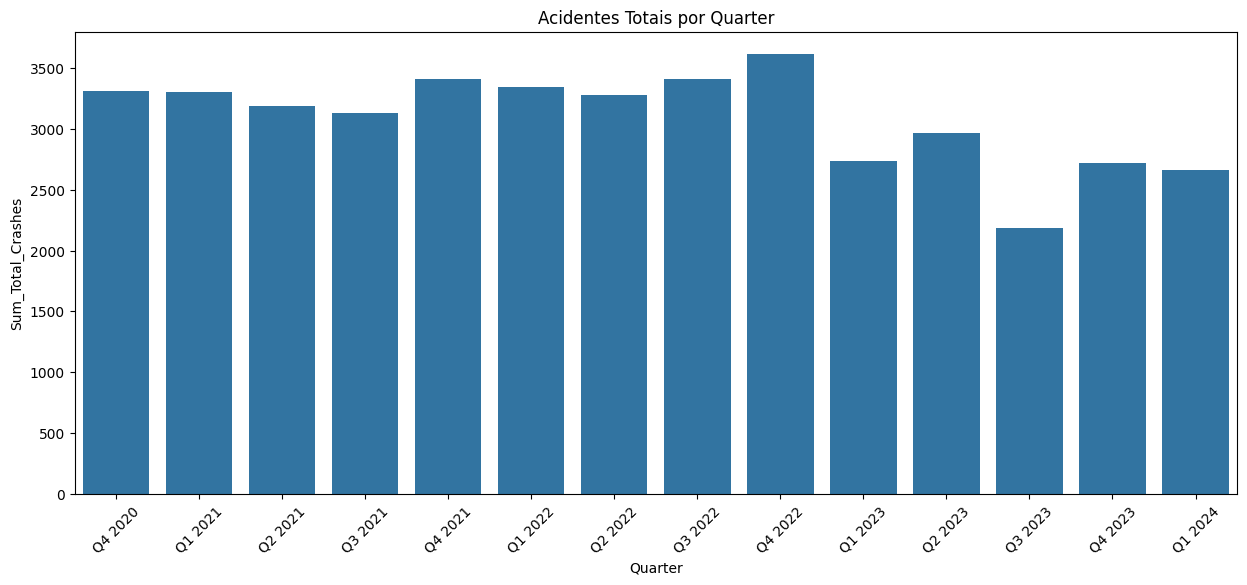

In [91]:
# Visualizando através de um gráfico
plt.figure(figsize=(15,6))
sns.barplot(x='Quarter', y='Sum_Total_Crashes', data = total_crashes_quarter.toPandas())
plt.title('Acidentes Totais por Quarter')
plt.xticks(rotation=45)
plt.show()

In [92]:
# Verificando as principais motivações para os acidentes por quarter
motivations_crashes_quarter = df.groupBy('Index_Quarter','Quarter').sum('Total_Crashes', 'SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors')\
                                .withColumnRenamed('sum(Total_Crashes)', 'Sum_Total_Crashes').sort('Index_Quarter')
motivations_crashes_quarter.show()

+-------------+-------+-----------------+--------+--------+--------+--------+------------------+
|Index_Quarter|Quarter|Sum_Total_Crashes|sum(SPV)|sum(DAD)|sum(PWR)|sum(FTQ)|sum(Other_Factors)|
+-------------+-------+-----------------+--------+--------+--------+--------+------------------+
|            1|Q4 2020|             3313|    2645|       7|       0|      14|              1706|
|            2|Q1 2021|             3301|    2429|       4|       3|      22|              1946|
|            3|Q2 2021|             3185|    2162|      10|       0|      36|              1775|
|            4|Q3 2021|             3134|      10|       4|      38|    2153|              1639|
|            5|Q4 2021|             3407|      11|       0|      22|    2265|              1808|
|            6|Q1 2022|             3345|       9|       0|      42|    2561|              1671|
|            7|Q2 2022|             3282|      14|       3|      22|    2418|              1923|
|            8|Q3 2022|       

A partir da tabela acima, notamos que em Q3 2022, há dados negativos de outros fatores para causa do acidente. Vamos entender da onde vem esses dados.

In [93]:
df.filter(col('Other_Factors') < 0).show(10)
df = df.withColumn('Other_Factors', when(col('Other_Factors') < 0, 0).otherwise(col('Other_Factors')))
df.filter(col('Other_Factors') < 0).show()

+-------------+-------+--------+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+
|Index_Quarter|Quarter|   State|Total_Crashes|Num_Injured|Num_Killed|Total_Vehicles_Involved|SPV|DAD|PWR|FTQ|Other_Factors|
+-------------+-------+--------+-------------+-----------+----------+-----------------------+---+---+---+---+-------------+
|            8|Q3 2022|     FCT|          464|        784|       109|                     23|  0|  0|  2|369|         -348|
|            8|Q3 2022|    Ogun|          306|        718|       102|                     27|  1|  0|  0|313|         -287|
|            8|Q3 2022|Nasarawa|          241|        626|        78|                     37|  1|  0|  0|129|          -93|
|            8|Q3 2022|  Kaduna|          192|        744|       164|                      4|  2|  0|  3|119|         -120|
|            8|Q3 2022|     Oyo|          166|        514|        84|                      1|  0|  0|  2|105|         -106|
|       

<p> Foi feita a substituição desses casos, pois não fazia sentido ter uma contagem negativa no número de fatores de um acidente. <br>
A partir disso, vamos refazer nossa tabela das principais motivações de acidente </p>

In [94]:
# Verificando as principais motivações para os acidentes por quarter
motivations_crashes_quarter = df.groupBy('Index_Quarter','Quarter').sum('Total_Crashes', 'SPV', 'DAD', 'PWR', 'FTQ', 'Other_Factors')\
                                .withColumnRenamed('sum(Total_Crashes)', 'Sum_Total_Crashes').sort('Index_Quarter')
motivations_crashes_quarter.show()

+-------------+-------+-----------------+--------+--------+--------+--------+------------------+
|Index_Quarter|Quarter|Sum_Total_Crashes|sum(SPV)|sum(DAD)|sum(PWR)|sum(FTQ)|sum(Other_Factors)|
+-------------+-------+-----------------+--------+--------+--------+--------+------------------+
|            1|Q4 2020|             3313|    2645|       7|       0|      14|              1706|
|            2|Q1 2021|             3301|    2429|       4|       3|      22|              1946|
|            3|Q2 2021|             3185|    2162|      10|       0|      36|              1775|
|            4|Q3 2021|             3134|      10|       4|      38|    2153|              1639|
|            5|Q4 2021|             3407|      11|       0|      22|    2265|              1808|
|            6|Q1 2022|             3345|       9|       0|      42|    2561|              1671|
|            7|Q2 2022|             3282|      14|       3|      22|    2418|              1923|
|            8|Q3 2022|       

<p> Notamos uma nova anomalia, aparentemente os dados da coluna SPV e FTQ foram invertidos (dado os valores correspondentes em sua média), entre o período de Q3 2021 até Q3 2022 <br>
Vamos fazer a inversão desses valores para esses quarters para continuarmos nossa análise </p>

In [95]:
# # Parar a SparkSession
spark.stop()